# Computer Vision - Assignment 0 - Introduction to OpenCV

#### Bonus: 4 points   |   Due date: September 30, 23:59   |   Submission site: https://pradogrado2223.ugr.es/

### Student's Full Name: Pedro Ramos Suárez

The first step is to connect with Google Drive and import the suitable libraries. 

In [97]:
#  We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive')
import os
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/MyDrive/images/',route)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# We import the modules to use
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
# With this backend, the output of plotting commands is displayed inline within 
# frontends like the Jupyter notebook, directly below the code cell that produced 
# it. The resulting plots will then also be stored in the notebook document.
# See https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline

# Exercise 1

Write a function (`readIm`) that reads an image file and displays it either in grayscale or color. `flagColor` is the variable that determines whether the image is displayed in grayscale or color. Depending on the value of `flagColor` we will have a grayscale image (if `0`) or a color image (if `1`). By default, omitting the `flagColor` parameter makes it `flagColor=1` (color). Show that the function works correctly by displaying one grayscale and one color image. 

#### Solution



In [99]:
def readIm(filename, flagColor=1):
  # Read image
  image = cv2.imread(filename, flagColor)

  # Swap BGR to RGB
  if flagColor == 1:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

We display the color version of the `logoOpenCV.jpg` image (three channels: RGB in matplotlib or BGR in OpenCV)

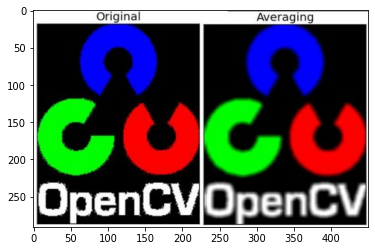

In [100]:
im_color = readIm(get_image('logoOpenCV.jpg'), 1)
plt.imshow(im_color)

We display the same image in grayscale (one channel)





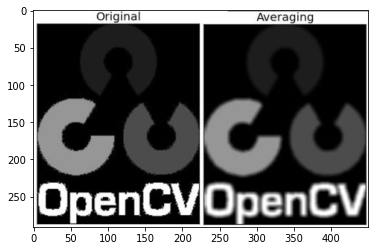

In [101]:
im_gray = readIm(get_image('logoOpenCV.jpg'), 0)
plt.imshow(im_gray, cmap='gray')

---

# Exercise 2

Write a function that displays an array of arbitrary real numbers (that must include positive and negative values). This function should handle images with one and three bands/channels. You have to display visual examples with random images and real images in both scenarios, one-channel (grayscale) and three-channels (RGB). Hint: band values have to be shifted and scaled in the proper range ([0,1]) to avoid information loss.

#### Solution

In [102]:
def rangeDisplay01(im, flag_GLOBAL):
  # Check image type (grayscale or color)
  if len(im.shape) == 2 or flag_GLOBAL == 1:
    # Normalize the grayscale image or globally the RGB image
    # Compute range and apply normalization
    max = im.max()
    min = im.min()
    im = (im - min)/(max - min)
  else:
    # Normalize each band as a grayscale image
    norm = np.zeros(im.shape, dtype=float)
    min = np.min(im, axis=(0, 1))
    max = np.max(im, axis=(0, 1))
    im = (im[:, :] - min) / (max - min)

  return im

Una pregunta que podemos hacernos es que normalización tiene más sentido hacer, si normalizar por canales o normalizar de forma global.

Si normalizamos de forma global, al escalar los tres colores de la misma forma mantenemos la proporción de colores, obteniéndo como resultado el mismo color, mientras que si normalizamos por canal estamos escalando cada color de manera distinta, modificando el color resultante.

Por ejemplo, si tomamos el siguiente trozo de la imagen ''orapple.jpg'':

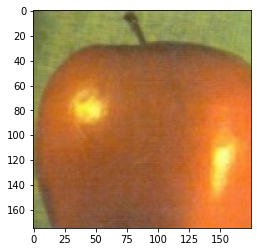

In [103]:
im = readIm(get_image('orapple.jpg'), 1)[25:200, 25:200]
plt.imshow(im)

Para comparar los resultados de normalizar de forma global o por canal, utilizaremos una función desarrollada en el Ejercicio 3 (nótese que es necesario ejecutar dicha función primero para que esta siguiente celda no de error):

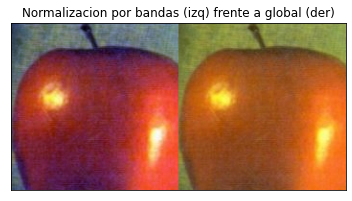

In [104]:
im = readIm(get_image('orapple.jpg'), 1)[25:200, 25:200]
vim = [rangeDisplay01(im, 0), rangeDisplay01(im, 1)]
im = displayMI_NES(vim)
displayIm(im, title='Normalizacion por bandas (izq) frente a global (der)')

Nótese que, si todos los colores están en el mismo rango (por ejemplo, si tenemos un pixel blanco (255, 255, 255) y otro negro (0, 0, 0), todos los intervalos son [0, 255]), la normalización por bandas será igual a normalizar de forma global.

Si el color no nos importa, si puede tener sentido normalizar cada color por separado para así tener los tres centrados en el intervalo [0, 1].

Let's write a function to display any image  with a title

In [105]:
def displayIm(im, title='Result', factor=1, showFlag=np.True_):  
  # Normalize range
  im = rangeDisplay01(im, 1)

  fig, ax = plt.subplots()
  # Display the image
  if len(im.shape) == 3:
    # im has three channels (RGB)
    ax.imshow(im)
  else:
    # im has a single channel (Grayscale)
    ax.imshow(im, cmap='gray')
    
  figure_size = plt.gcf().get_size_inches()
  plt.title(title) # Adding title
  plt.gcf().set_size_inches(factor * figure_size)
  plt.xticks([]), plt.yticks([]) # Axis label off
  if showFlag: plt.show()

Let's test this function using both RGB and gray level images

In [106]:
rand_mono = (np.random.rand(50, 50)-0.5)*255
rand_multi = (np.random.rand(50, 50, 3)-0.5)*255

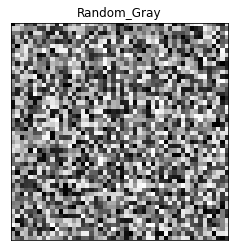

In [107]:
displayIm(rand_mono,'Random_Gray')

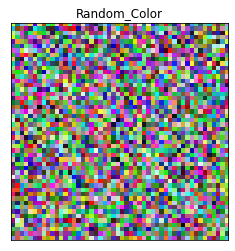

In [108]:
displayIm(rand_multi, 'Random_Color')

Let's try with the real images given above. 

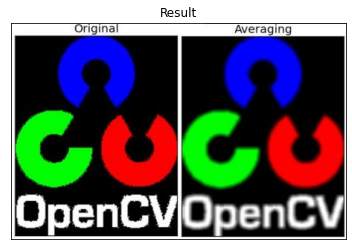

In [109]:
displayIm(im_color)

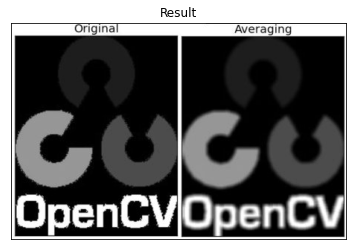

In [110]:
displayIm(im_gray)

---

# Exercise 3

Write a function that takes as input a sequence/list of images (`vim`) and display them simultaneously on the same canvas. Consider the following cases: (a) images with the same size and number of channels, (b) images with different sizes but the same number of channels, and (c) images with different size and number of channels. Show visual examples of the three scenarios. 

#### Solution

Case (a): the student can concatenate the images by rows and columns using the numpy functions vstack() and hstack().

Case (b): Here a good policy could be to insert the largest image in the upper left corner of the canvas and add new images from the left along the bottom and diagonal iteratively.

Case (c): Convert all single-channel images to three-channel images and go to case (b).

Students are allowed to create two functions (`displayMI_ES` and `displayMI_NES`) to separately tackle scenarios (a) and (b)-(c), respectively. 

Primero, para saber cómo distribuir las imágenes, utilizaremos la siguiente función, que utiliza la raíz cuadrada del número de imágenes para calcular el número de filas y columnas:

In [111]:
def imDistribution(size):
  # Calculates the number of rows and columns for the "best" distribution of
  # multiple images using the square root of the number of images
  root = math.sqrt(size)
  rows = root
  columns = root
  if root % 1 != 0:
      columns += 1
      if root % 1 > 0.5:
        rows += 1
  return int(rows), int(columns)

In [112]:
def displayMI_ES(vim):
  # Let's start with case (a). We concatenate the images by columns, or by rows 
  # and columns, depending on the number of images and their dimensions
  rows, columns = imDistribution(len(vim))

  # First row
  out = vim[0].copy()
  for i in range(1, columns):
    out = np.hstack((out, vim[i]))

  # Adding more rows
  for i in range(1, rows):
    temp = vim[i * columns].copy()
    for j in range(1, columns):
      if i * columns + j < len(vim):
        temp = np.hstack((temp, vim[i * columns + j]))
      else:
        temp = np.hstack((temp, np.zeros(vim[i*columns].shape, dtype=vim[i*columns].dtype)))
    out = np.vstack((out, temp))

  # Adding title and factor
  title = 'Exercise 3 (a)'
  factor = 1

  return displayIm(out, title, factor)

Let's display two different configurations

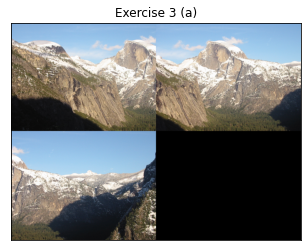

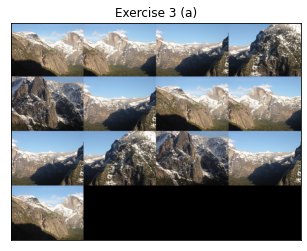

In [113]:
imcolor_1 = readIm(get_image('yosemite1.jpg'))
imcolor_2 = readIm(get_image('yosemite2.jpg'))
imcolor_3 = readIm(get_image('yosemite3.jpg'))
imcolor_4 = readIm(get_image('yosemite4.jpg'))
imcolor_5 = readIm(get_image('yosemite5.jpg'))
vim=[imcolor_1, imcolor_2, imcolor_3]
displayMI_ES(vim)
vim=[imcolor_1, imcolor_2, imcolor_3,imcolor_4, imcolor_5, imcolor_3,imcolor_1, imcolor_2, imcolor_3,imcolor_4, imcolor_5, imcolor_3,imcolor_1]
displayMI_ES(vim)

Let us now consider the case of images with different sizes but the same number of channels. We can start by placing the first (the largest) in the top-left corner. Then we concatenate by columns and rows the rest of images.

Para ello, definimos una nueva función que nos permite extender una imagen añadiendo filas o columnas en negro, para así poder tener todas las imagenes con el mismo tamaño:

In [114]:
def fillImage(im_, rows, columns):
  im = im_.copy()
  # Adding white rows
  if im.shape[0] < rows:
    im = np.vstack((im, np.zeros((rows - im.shape[0], im.shape[1], im.shape[2]))))
  # Adding white columns  
  if im.shape[1] < columns:
    im = np.hstack((im, np.zeros((im.shape[0], columns - im.shape[1], im.shape[2]))))
  return im

Definimos la función del ejercicio.

Nótese que parte del código está repetido del caso de imagenes con el mismo tamaño (apartado a) ya que, como la función de dicho apartado nos devuelve la función que muestra la imagen y en la plantilla de este guión, para la función de este apartado, con imagenes de distinto tamaño, nos devolvía la imagen como una matriz, no podemos reutilizar el código anterior.

In [115]:
def displayMI_NES(vim):
  # For arrays containing gray and RGB images, we convert all in RGB images
  for i in range(len(vim)):
    if len(vim[i].shape) == 2:
      vim[i] = cv2.cvtColor(vim[i],cv2.COLOR_GRAY2RGB)

  rows, columns = imDistribution(len(vim))

  # Max size of the images in each row
  rowSize = []
  for i in range(rows):
    max = 0
    for j in range(columns):
      if int(i * columns + j) < len(vim) and vim[int(i * columns + j)].shape[0] > max:
        max = vim[int(i * columns + j)].shape[0]
    rowSize.append(max)

  # Max size of the images in each column
  columnSize = []
  for j in range(columns):
    max = 0
    for i in range(rows):
      if int(i * columns + j) < len(vim) and vim[int(i * columns + j)].shape[1] > max:
        max = vim[int(i * columns + j)].shape[1]
    columnSize.append(max)
    
  # Extend all the images to the size of the largest images of their row and column
  extendedVim = []
  for i in range(rows):
    for j in range(columns):
      extendedVim.append(fillImage(vim[int(i * columns + j)], rowSize[i], columnSize[j]))

  # Almost the same code as in displayMI_ES()
  # First row
  out = extendedVim[0].copy()
  for i in range(1, columns):
    out = np.hstack((out, extendedVim[i]))

  # Adding more rows
  for i in range(1, rows):
    temp = extendedVim[i * columns].copy()
    for j in range(1, columns):
      if i * columns + j < len(extendedVim):
        temp = np.hstack((temp, extendedVim[i * columns + j]))
      else:
        temp = np.hstack((temp, np.zeros(extendedVim[i*columns].shape, dtype=extendedVim[i*columns].dtype)))
    out = np.vstack((out, temp))
    
  return out

Probamos primero el apartado b) con imágenes de distinto tamaño pero todas en formato RGB.

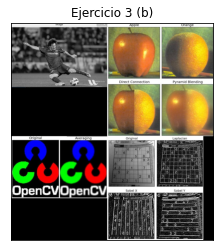

In [116]:
imcolor_1 = readIm(get_image('dave.jpg'))
imcolor_2 = readIm(get_image('logoOpenCV.jpg'))
imcolor_3 = readIm(get_image('orapple.jpg'))
imcolor_4 = readIm(get_image('messi.jpg'))
vim=[imcolor_4,imcolor_3,imcolor_2,imcolor_1]
outIm=displayMI_NES(vim)
displayIm(outIm, title='Ejercicio 3 (b)')

Por último, probemos el caso del apartado c) con imágenes de distinto tamaño y distinto formato de colores:

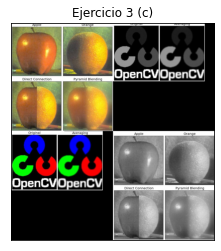

In [117]:
imcolor_1 = readIm(get_image('orapple.jpg'))
imcolor_2 = readIm(get_image('logoOpenCV.jpg'))
imgray_1 = readIm(get_image('orapple.jpg'), 0)
imgray_2 = readIm(get_image('logoOpenCV.jpg'), 0)
vim=[imcolor_1,imgray_2,imcolor_2,imgray_1]
outIm=displayMI_NES(vim)
displayIm(outIm, title='Ejercicio 3 (c)')

---

# Exercise 4

Write a function that modifies the color in an image for each of the pixel coordinates included in a list. Specifically, students must insert a green square with a side of 50 pixels in the center of the image. The key idea of this exercise is to understand how to modify the pixel values in an image (a 2D spatial array of pixels, where each pixel is defined by one (illumination in grayscale) or three values (RGB-color)).

#### Solution



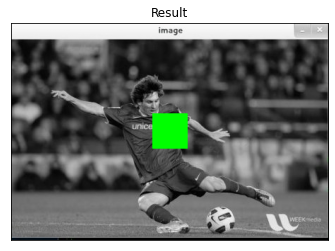

In [118]:
def changePixelValues(im, cp, nv):
  # cp is a vector of pixel coordinates
  # nv is a vector with the new values
  # replace the values of cp with the nv values
  for i in range(len(cp)):
    im[cp[i,0], cp[i,1]] = nv[i]
  return displayIm(im)

# Read Image
im = readIm(get_image('messi.jpg'))

# Create the list of points with the requested shape
rows = np.arange(int(im.shape[0]/2) - 25, int(im.shape[0]/2) + 25)
columns = np.arange(int(im.shape[1]/2) - 25, int(im.shape[1]/2) + 25)
cp = np.array(np.meshgrid(rows, columns)).T.reshape(-1,2)

# Create the matrix of the new pixels
nv = np.zeros((50 * 50, 3))
nv[:,1] = 255

changePixelValues(im, cp, nv) 

---

# Exercise 5

Write a function (`print_images_titles`) able to display multiple images, within the same canvas, including specific titles for each one of them. The main novelty of this exercise, with respect to Exercise 3, is the fact of adding a title for each subimage. `print_images_titles` is fed with a list of images and a list of titles. `matplotlib` functions like `add_subplot` or `subplot` can help in this regard.

#### Solution

Utilizamos subplots de matplotlib y la función para calcular la mejor distribución de filas y columnas defina en el ejercicio 3.

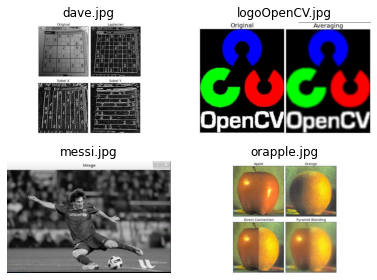

In [119]:
def print_images_titles(vim, titles=None, rows=0):
  fig = plt.figure()
  i=1

  if rows > 0:
    # Funcion defined in exercise 3 for the 'best' distribution
    columns = math.ceil(len(vim)/rows)
  else:
    rows, columns = imDistribution(len(vim))

  # Add images
  for image in vim:
    ax = fig.add_subplot(rows, columns, i)
    if titles is not None:
      ax.title.set_text(titles[i-1])
    ax.imshow(image)
    ax.axis('off') # Remove axis
    i+=1
  fig.tight_layout()


im1 = readIm(get_image('dave.jpg'))
im2 = readIm(get_image('logoOpenCV.jpg'))
im3 = readIm(get_image('messi.jpg'))
im4 = readIm(get_image('orapple.jpg'))
vim = [im1, im2, im3, im4]    
titles = ['dave.jpg','logoOpenCV.jpg','messi.jpg','orapple.jpg']

print_images_titles(vim, titles)